In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar
import theano.tensor as tt


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

def OUcross(data1,data2,deltat):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult2(x1,deltat)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult2(x2,deltat)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)

In [4]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


In [22]:
# parameters for coupled oscillator
K,D,C = 1.0,1.0,3.0
sN = 0.7 # 50% error 0.7*0.7=0.49
delta_t = 0.1
print(np.exp(-0.2))
#M=1000 # number of data sets
N=4000 # length of data set
#print(np.exp(-delta_t*D/A))

0.8187307530779818


In [23]:
data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
data2 = langevin.time_series(A=1/(K+C), D=D, delta_t=delta_t, N=N)
x1 = (data1 + data2)/2
x2 = (data1 - data2)/2
print(OUcross(x1,x2,delta_t))

(2.7667313546950054, 0.15851079835721688)


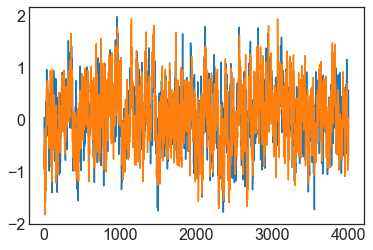

In [24]:
plt.plot(x1)
plt.plot(x2)

In [25]:
print(np.std(x1)**2,np.std(x2)**2)
print(pearsonr(x1,x2))
snoise = np.sqrt((np.std(x1)**2+np.std(x2)**2))*sN

0.31180970602121666 0.3170066570899915
(0.5765900310389565, 0.0)


In [26]:
# now lets add some noise to the data
x1N = x1 + np.random.normal(loc=0.0, scale=snoise, size=N)
x2N = x2 + np.random.normal(loc=0.0, scale=snoise, size=N)

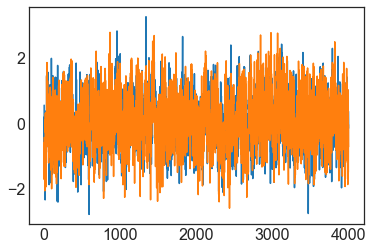

In [27]:
plt.plot(x1N)
plt.plot(x2N)

In [28]:
print(np.std(x1N)**2,np.std(x2N)**2)
print(pearsonr(x1N,x2N))

0.6048582747297557 0.6288566175289734
(0.29698066355937014, 2.943002828007507e-82)


In [29]:
a_bound=2
alp=2
bet=1
D=1.0
# compile model for reuse
with pm.Model() as model:
    A1 = pm.Uniform('A1', lower=0, upper=a_bound)
    A2 = pm.Uniform('A2', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=3)
#    sigma2 = pm.Uniform('sigma2',lower=0,upper=3)
    
    B1 = pm.Deterministic('B1',pm.math.exp(-delta_t * D / A1))
    B2 = pm.Deterministic('B2',pm.math.exp(-delta_t * D / A2))
                          
    path1 = Ornstein_Uhlenbeck('path1',A=A1, B=B1,shape=len(x1N))
    path2 = Ornstein_Uhlenbeck('path2',A=A2, B=B2,shape=len(x2N))
                          
    dataObs1 = pm.Normal('dataObs1',mu=(path1+path2)/2,sigma=sigma,observed=x1N)
    dataObs2 = pm.Normal('dataObs2',mu=(path1-path2)/2,sigma=sigma,observed=x2N)
    trace = pm.sample(10000,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path2, path1, sigma, A2, A1]
Sampling 4 chains, 0 divergences: 100%|██████████| 48000/48000 [13:40<00:00, 58.50draws/s]
The acceptance probability does not match the target. It is 0.7184494756925439, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6950928368505275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6910408331118715, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6884075984047946, but should be close to 0.8. Try to increase the number of tuning steps.


In [37]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path1[0],-0.796,0.477,-1.688,0.101,0.002,0.002,54062.0,47161.0,54089.0,36361.0,1.0
path1[1],-1.186,0.430,-2.005,-0.396,0.002,0.001,65017.0,58805.0,65048.0,34317.0,1.0
path1[2],-1.206,0.414,-1.985,-0.431,0.002,0.001,65514.0,60993.0,65516.0,35154.0,1.0
path1[3],-1.264,0.408,-2.036,-0.501,0.002,0.001,62549.0,58271.0,62527.0,35687.0,1.0
path1[4],-1.476,0.406,-2.255,-0.729,0.002,0.001,59955.0,57274.0,59945.0,35963.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
A1,1.025,0.079,0.883,1.174,0.000,0.000,36798.0,35176.0,39578.0,23878.0,1.0
A2,0.271,0.016,0.241,0.303,0.000,0.000,27217.0,27217.0,27212.0,33666.0,1.0
sigma,0.548,0.006,0.538,0.559,0.000,0.000,36653.0,36653.0,36651.0,34672.0,1.0
B1,0.907,0.007,0.894,0.919,0.000,0.000,39568.0,39442.0,39578.0,23878.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8da94c1400>,
      dtype=object)

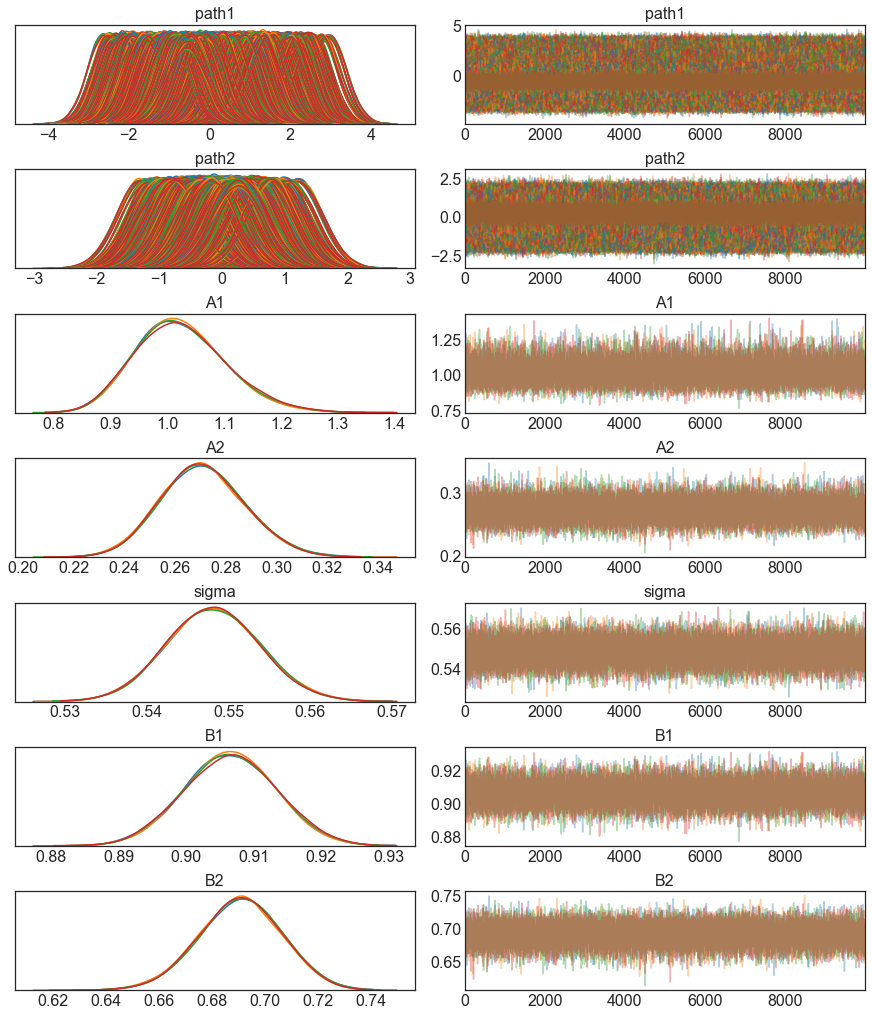

In [38]:
pm.traceplot(trace)

In [30]:
A1 = np.mean(trace['A1'])
A2 = np.mean(trace['A2'])
dA1 = np.std(trace['A1'])
dA2 = np.std(trace['A2'])

In [31]:
print((A1-A2)/A2)
print(np.sqrt(dA1**2+dA1**2*dA2**2/A2**4))

2.7801961231643264
0.08065866076308402


In [32]:
avgpathplus = np.mean(trace['path1'],axis=0)
stdpathplus = np.std(trace['path1'],axis=0)
print(avgpathplus.shape)
avgpathplus_norm=avgpathplus/np.std(avgpathplus)

(4000,)


In [33]:
avgpathminus = np.mean(trace['path2'],axis=0)
stdpathminus = np.std(trace['path2'],axis=0)
print(avgpathminus.shape)
avgpathminus_norm=avgpathminus/np.std(avgpathminus)

(4000,)


In [34]:
avgpath1 = (avgpathplus+avgpathminus)/2
avgpath2 = (avgpathplus-avgpathminus)/2
avgpath1_norm = avgpath1/np.std(avgpath1)
avgpath2_norm = avgpath2/np.std(avgpath2)
print(np.std(avgpath1)**2,np.std(avgpath2)**2)
print(OUcross(avgpath1_norm,avgpath2_norm,delta_t))
print("Pearson avgpath1:avgpath2",pearsonr(avgpath1,avgpath2))

0.23908759669113483 0.24051240482310393
(5.475485256972434, 0.6247643221336584)
Pearson avgpath1:avgpath2 (0.7289771860435352, 0.0)


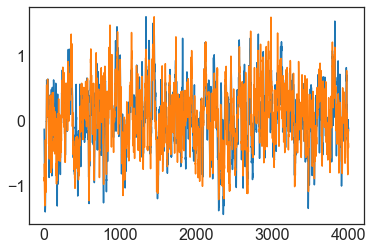

In [35]:
plt.plot(avgpath1)
plt.plot(avgpath2)

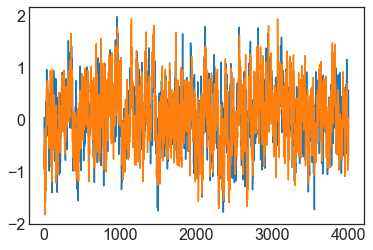

In [36]:
plt.plot(x1)
plt.plot(x2)